# Barcode Selection

QC for barcodes- remove barcodes with few counts.

In [ ]:
library(SnapATAC)
library(GenomicRanges)

# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_snATAC
# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_brain_5k

In [7]:
file.list = c("/srv/scratch/surag/scATAC-reprog/snap/D0.snap", 
              "/srv/scratch/surag/scATAC-reprog/snap/D2.snap",
              "/srv/scratch/surag/scATAC-reprog/snap/D4.snap",
              "/srv/scratch/surag/scATAC-reprog/snap/D6.snap",s
              "/srv/scratch/surag/scATAC-reprog/snap/D8.snap",
              "/srv/scratch/surag/scATAC-reprog/snap/D10.snap",
              "/srv/scratch/surag/scATAC-reprog/snap/D12.snap",
              "/srv/scratch/surag/scATAC-reprog/snap/D14.snap",
              "/srv/scratch/surag/scATAC-reprog/snap/D28.snap")
sample.list = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "D28")

x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = sample.list[i])
    x.sp
})

Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...


In [8]:
names(x.sp.ls) = sample.list

In [9]:
x.sp.ls

$D0
number of barcodes: 464829
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D2
number of barcodes: 388502
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D4
number of barcodes: 438601
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D6
number of barcodes: 464452
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D8
number of barcodes: 499930
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D10
number of barcodes: 332340
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D12
number of barcodes: 360583
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D14
number of barcodes: 391393
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D28
number of barcodes: 461891
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0


In [10]:
showBinSizes("/srv/scratch/surag/scATAC-reprog/snap/D0.snap");

[1]  1000  2000    50 10000  5000

In [11]:
x.sp.list = lapply(seq(x.sp.ls), function(i) {
    x.sp = addBmatToSnap(x.sp.ls[[i]], bin.size=5000, num.cores=1)
    x.sp
})

Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...


In [12]:
library(TxDb.Hsapiens.UCSC.hg38.knownGene)

In [13]:
txdb = TxDb.Hsapiens.UCSC.hg38.knownGene

In [14]:
prom.hg38 = promoters(genes(txdb), upstream = 2000, downstream = 0)

In [15]:
prom.hg38

GRanges object with 24183 ranges and 1 metadata column:
            seqnames              ranges strand |     gene_id
               <Rle>           <IRanges>  <Rle> | <character>
          1    chr19   58362752-58364751      - |           1
         10     chr8   18389245-18391244      + |          10
        100    chr20   44651743-44653742      - |         100
       1000    chr18   28177447-28179446      - |        1000
  100009613    chr11   70075434-70077433      - |   100009613
        ...      ...                 ...    ... .         ...
       9991     chr9 112333668-112335667      - |        9991
       9992    chr21   34362024-34364023      + |        9992
       9993    chr22   19122455-19124454      - |        9993
       9994     chr6   89827894-89829893      + |        9994
       9997    chr22   50526440-50528439      - |        9997
  -------
  seqinfo: 455 sequences (1 circular) from hg38 genome

In [16]:
# check bins for all are same
for (i in seq(1,length(x.sp.list))) {
    if (!all(x.sp.list[[1]]@feature==x.sp.list[[i]]@feature)) {
        print("FEATURE MISMATCH")
    }
}

In [ ]:
overlaps = findOverlaps(x.sp.list[[1]]@feature, prom.hg38);
length(overlaps)

In [18]:
idy = queryHits(overlaps)

In [19]:
log_cov = log10(SnapATAC::rowSums(x.sp.list[[1]], mat="bmat")+1)
promoter_ratio = Matrix::rowSums(x.sp.list[[1]]@bmat[,idy]) / Matrix::rowSums(x.sp.list[[1]]@bmat);

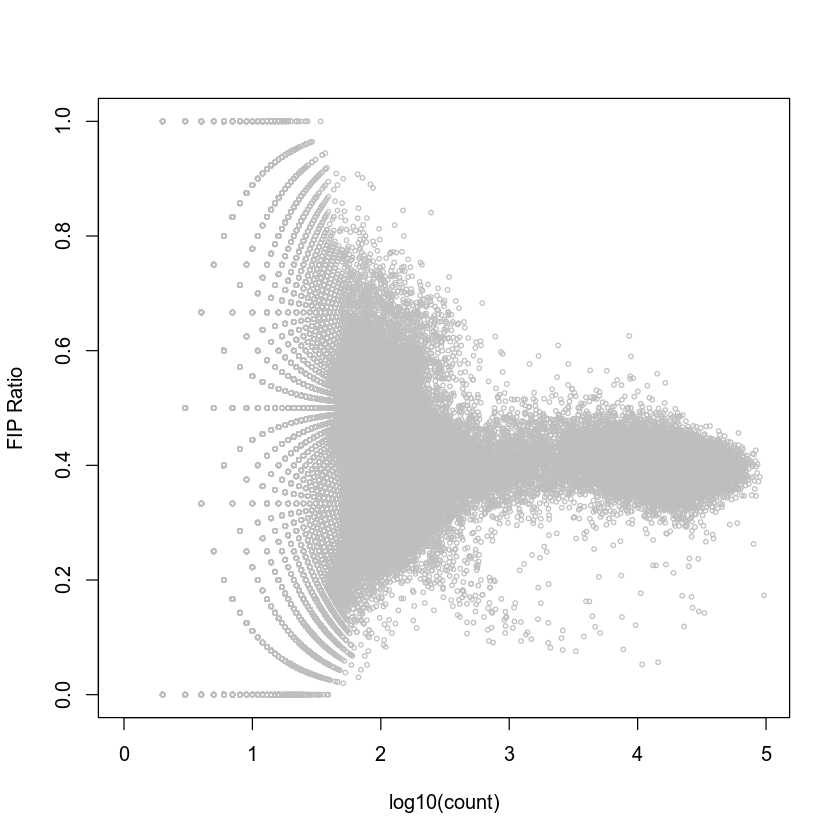

In [20]:
# plotting total counts vs fraction in promoters
# note that if bins are 5k then this may overestimate fraction in promoters
plot(log_cov, promoter_ratio, cex=0.5, col="grey", xlab="log10(count)", ylab="FIP Ratio", ylim=c(0,1 ));

In [21]:
idx = which(promoter_ratio > 0.2 & promoter_ratio < 0.8 & log_cov > 3);

In [22]:
rs = Matrix::rowSums(x.sp.list[[1]][idx, ]@bmat>0)

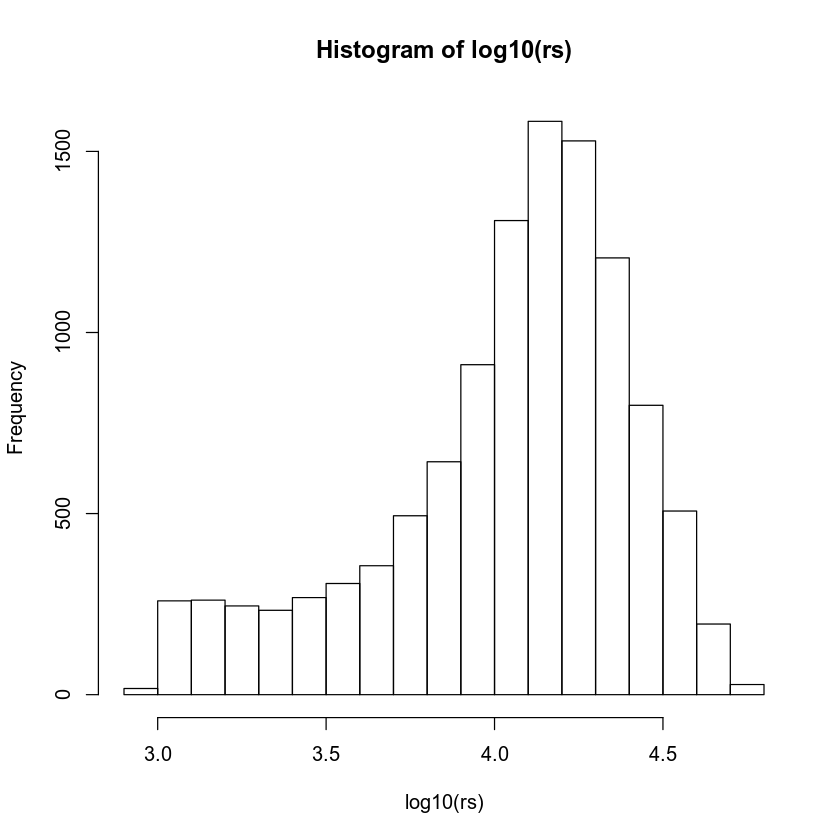

In [23]:
hist(log10(rs))

## Writing Selected Barcodes

In [26]:
PATH = sprintf("./barcodeLists/%s_5kb_logcov_gt3_promratio_bw_0.2_0.8", format(Sys.Date(), "%Y%m%d"))
PATH

[1] "./barcodeLists/20200201_5kb_logcov_gt3_promratio_bw_0.2_0.8"

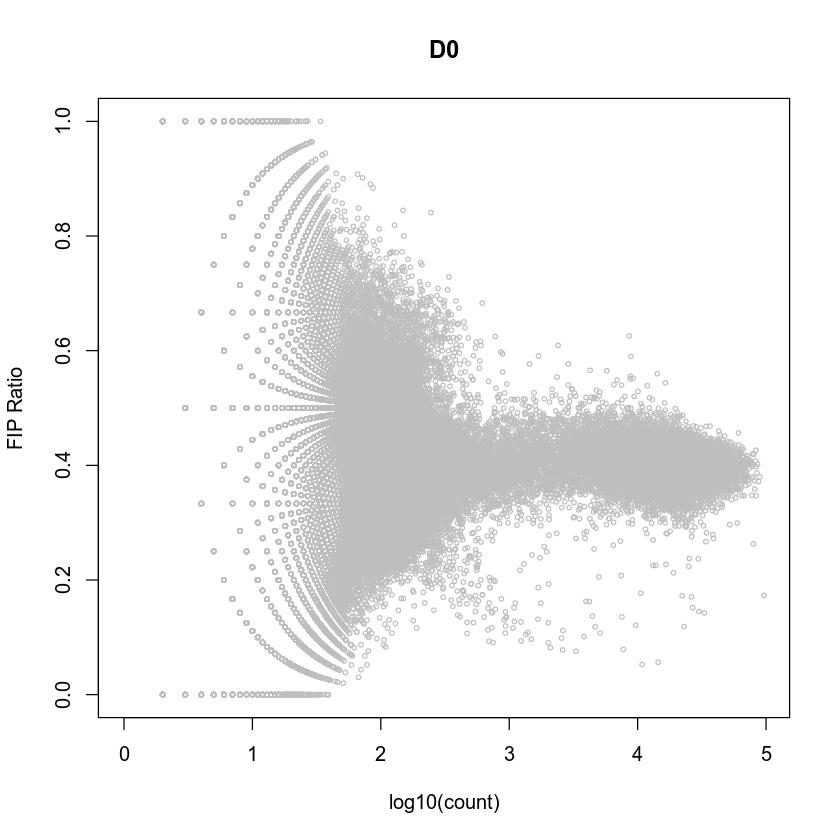

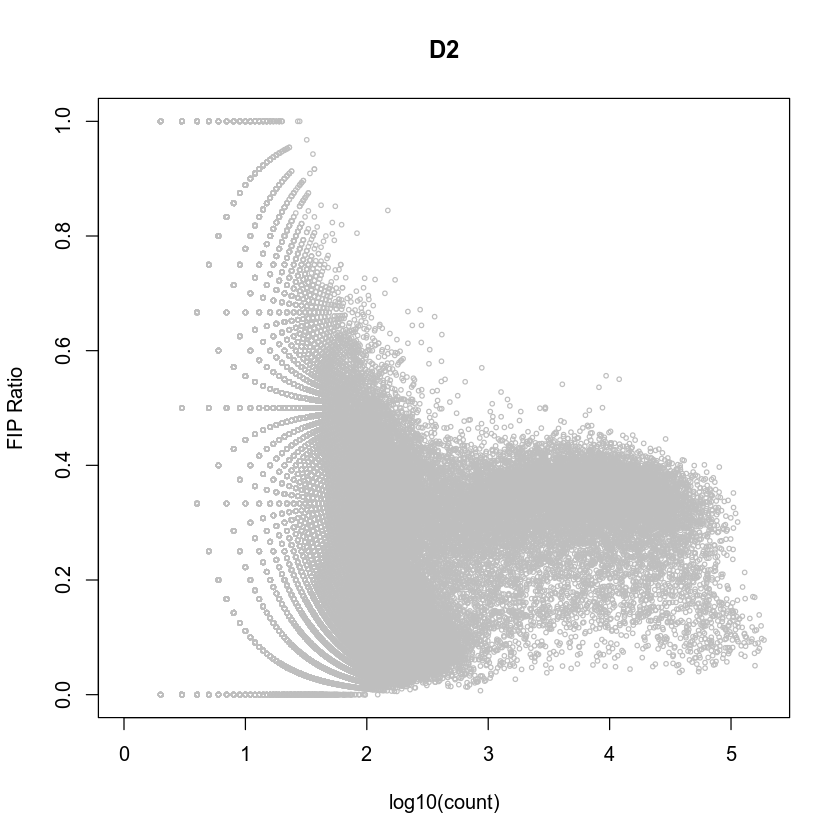

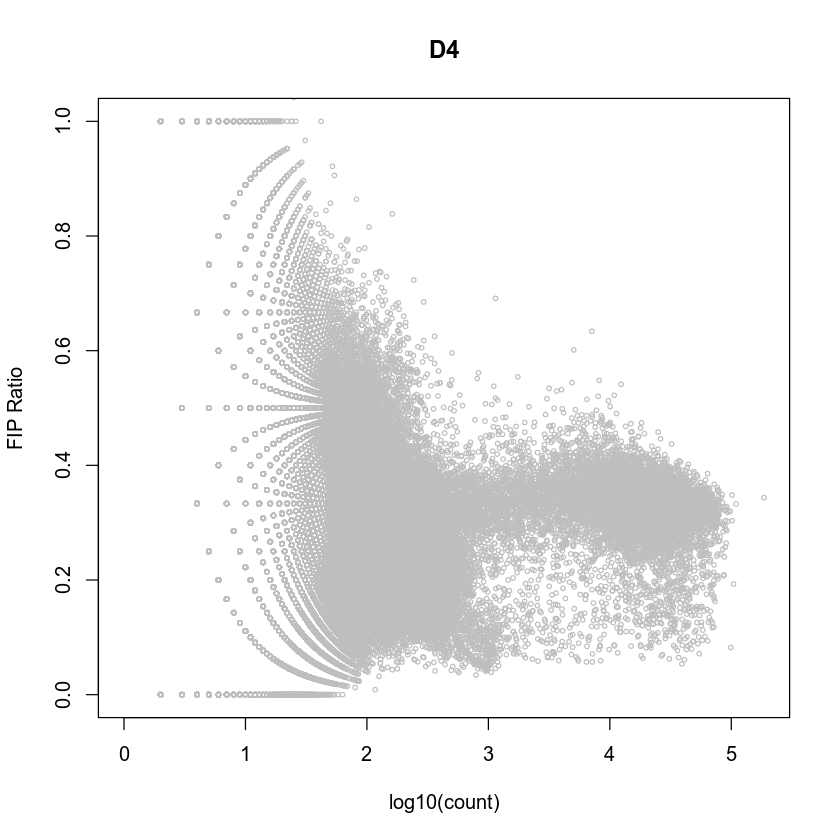

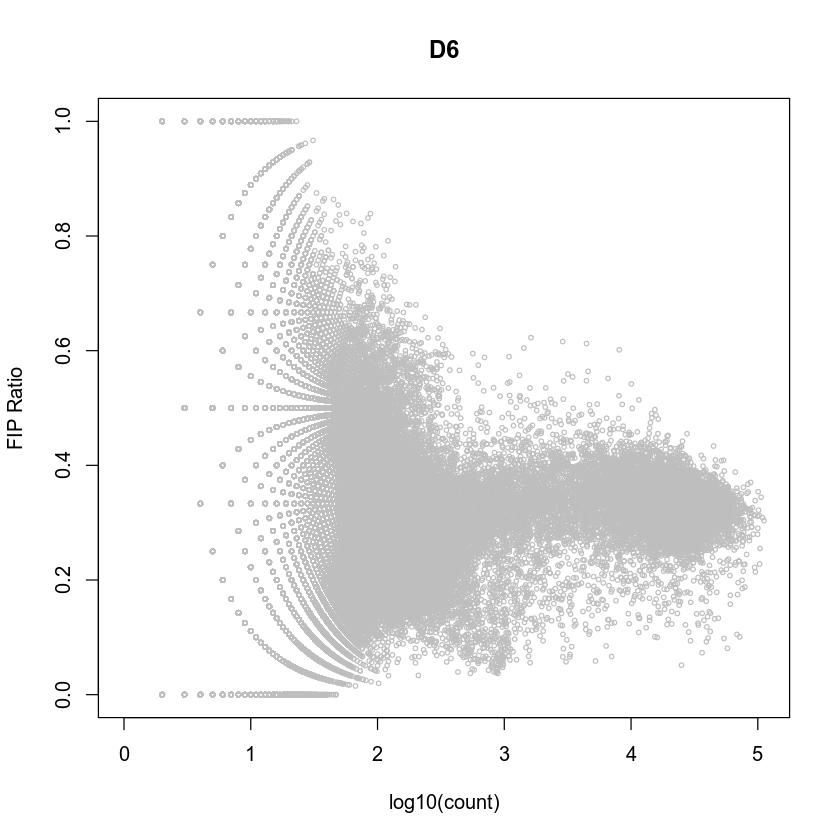

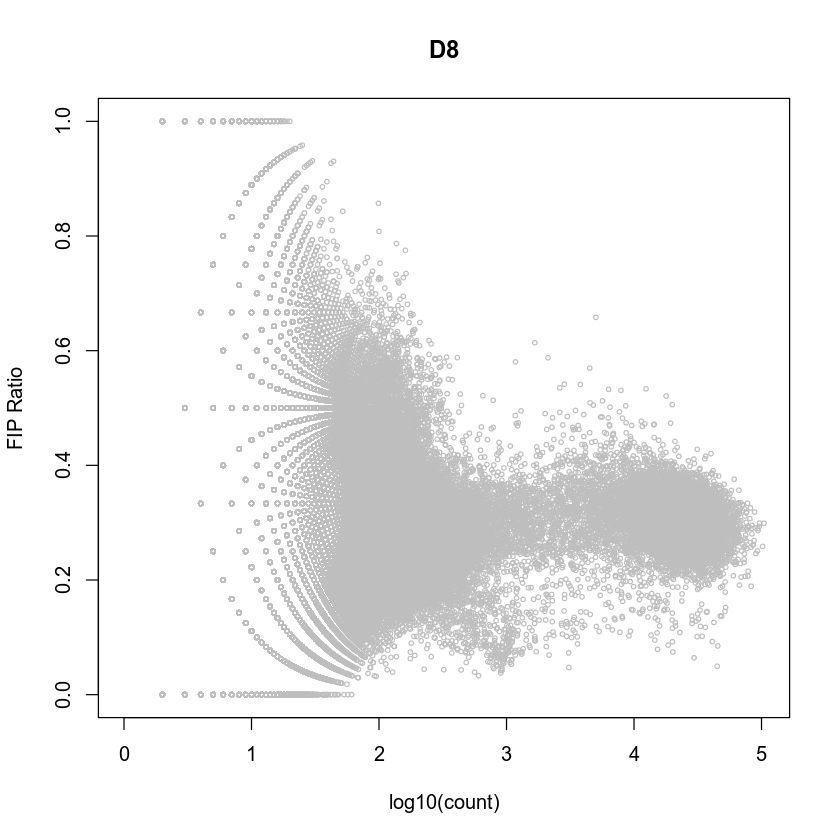

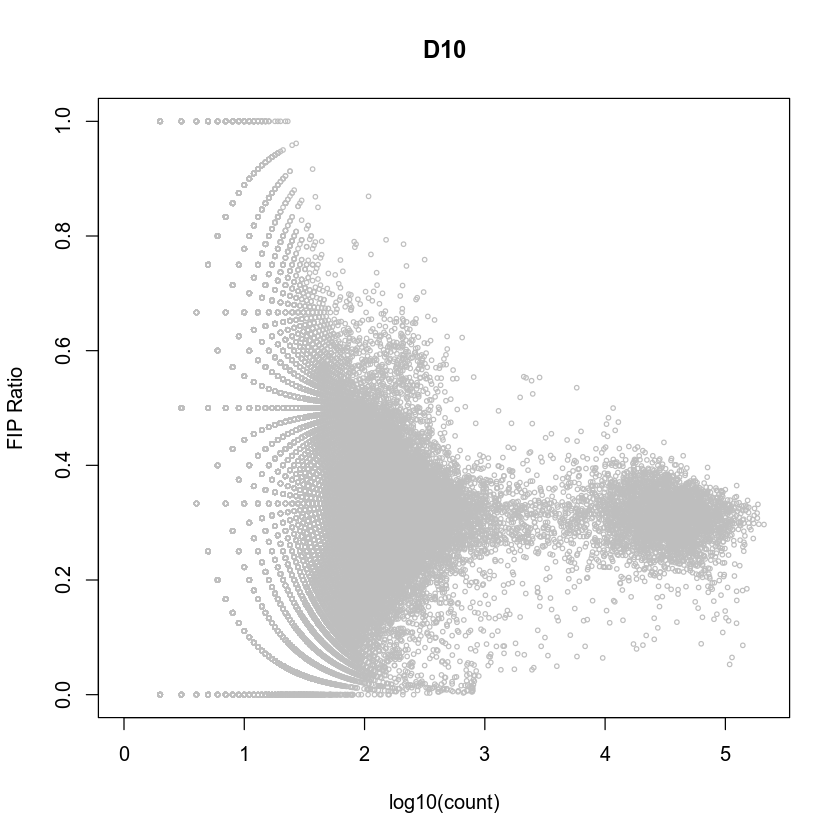

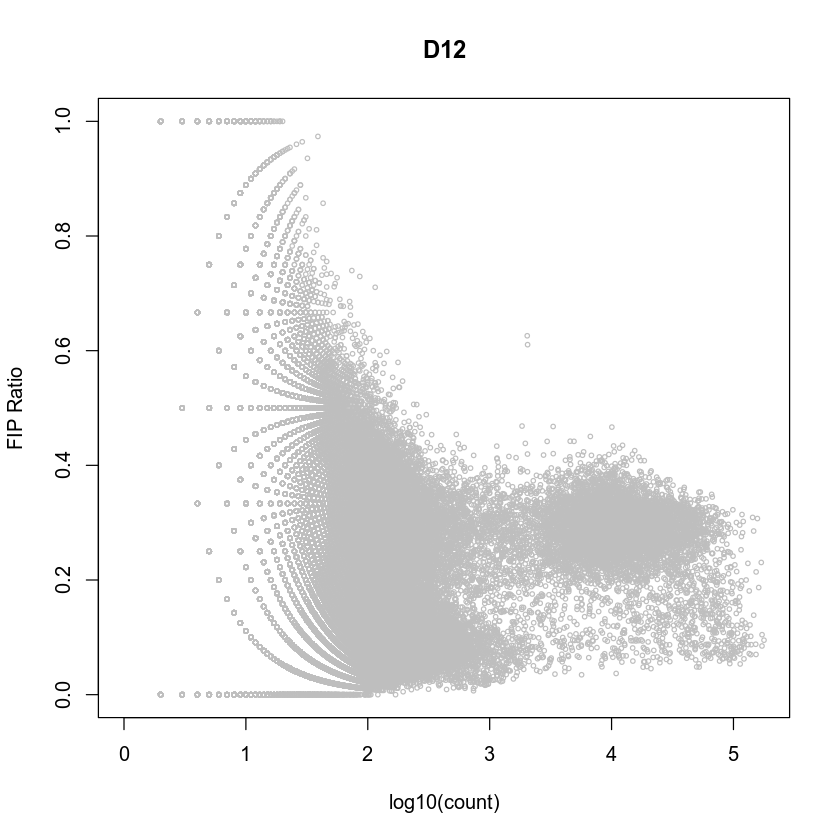

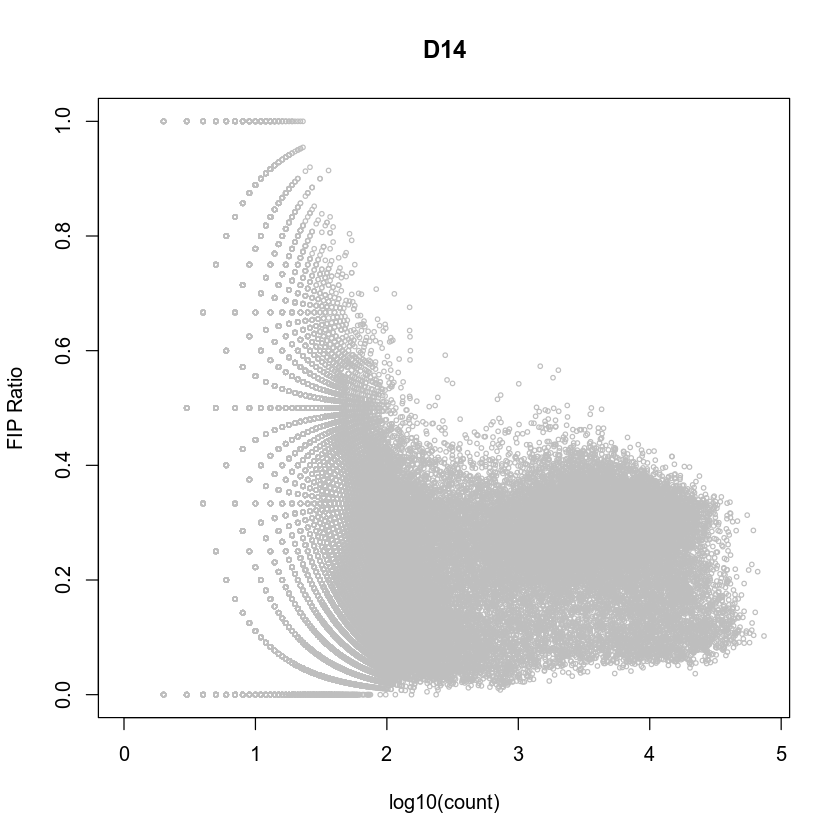

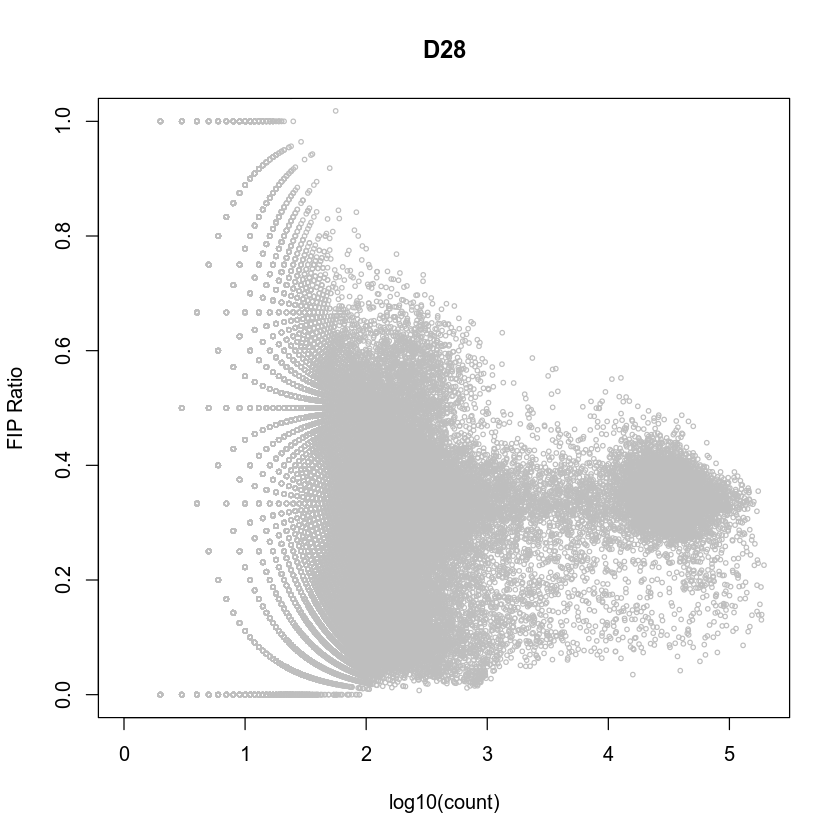

In [27]:
for (i in seq(1,length(x.sp.list))) {
    log_cov = log10(SnapATAC::rowSums(x.sp.list[[i]], mat="bmat")+1)
    promoter_ratio = Matrix::rowSums(x.sp.list[[i]]@bmat[,idy]) / Matrix::rowSums(x.sp.list[[i]]@bmat)
    plot(log_cov, promoter_ratio, cex=0.5, main=sample.list[i], col="grey", xlab="log10(count)", ylab="FIP Ratio", ylim=c(0,1 ))

    # choose which barcodes
    idx = which(promoter_ratio > 0.2 & promoter_ratio < 0.8 & log_cov > 3)

    # write
    path = sprintf("%s/%s.barcodes.txt", PATH, sample.list[i])
    write.table(x.sp.list[[i]][idx, ]@barcode, path, row.names = FALSE, col.names = FALSE, quote = FALSE)
}